In [1]:
from icepyx import query as ipd
import os
import shutil
from pathlib import Path
from pprint import pprint

import pandas as pd

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils_atl06 import *

# Example

In [4]:
short_name = 'ATL06'
spatial_extent = [ -50.71,  65.73, -45.32,  68.08]
date_range = ['2019-06-01','2019-06-05']

In [ ]:
df = read_atl06(spatial_extent, 
                date_range, 
                time_start = "06:00:00", 
                time_end = "18:00:00",
                path = "./data/new_ATL06", 
                user = 'fsapienza', 
                email = 'fsapienza@berkeley.edu')

Available Granules: ['ATL06_20190601071608_09780303_003_01.h5', 'ATL06_20190601200102_09860305_003_01.h5', 'ATL06_20190605070748_10390303_003_01.h5']


In [6]:
df[df.q_flag == 1].shape

(5649, 32)

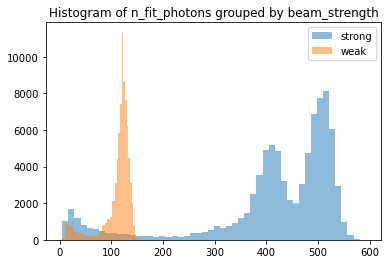

In [7]:
from utils import hist_df
hist_df(df[df.n_fit_photons < 10e3], 'n_fit_photons', 'beam_strength')

In [70]:
df['q_flag_1'] = df.apply(lambda row: 1 if (row.h_rb >= 1) else 0, axis = 1)
df['q_flag_2'] = df.apply(lambda row: 1 if (row.height_sigma >= 1) else 0, axis = 1)
df['q_flag_3'] = df.apply(lambda row: 1 if (row.snr_significance >= 0.02) else 0, axis = 1)
df['q_flag_4'] = df.apply(lambda row: 1 if (row.s_fg > 1) else 0, axis = 1)
df['q_flag_5'] = df.apply(lambda row: 1 if ( (row.beam_strength == 'strong' and row.n_fit_photons_ratio_w <= 4) or 
                                             (row.beam_strength == 'weak'   and row.n_fit_photons_ratio_w <= 1) ) else 0, axis = 1)

In [8]:
df.head()

,ground_track,time,segment_id,beam_strength,lat,lon,height,slope_dx,slope_dy,snr,...,c_flg_atm,msw,layer_flag,background,background_expected,q_flag_1,q_flag_2,q_flag_3,q_flag_4,q_flag_5
0,gt1l,2019-06-01 07:18:41.747013,371978,strong,66.862169,-45.326436,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
1,gt1l,2019-06-01 07:18:41.749913,371979,strong,66.862351,-45.326488,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
2,gt1l,2019-06-01 07:18:41.761213,371983,strong,66.863066,-45.326704,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
3,gt1l,2019-06-01 07:18:41.924563,372041,strong,66.873399,-45.329752,3.402823e+38,3.402823e+38,3.402823e+38,3.402823e+38,...,1,1,1,3.402823e+38,3.402823e+38,1,1,0,1,1
4,gt1l,2019-06-01 07:18:42.076715,372095,strong,66.883032,-45.332678,3.402823e+38,3.402823e+38,3.402823e+38,3.085928e-01,...,1,1,1,3.402823e+38,3.402823e+38,1,1,1,1,1


In [81]:
def p_a_cond_b (df, a, b):
    """
    Given a dataframes df, it computes the empirial conditionl probability
    """    
    
    assert all(np.unique(df[a]) == [0,1]), "Variable must be binary"
    assert all(np.unique(df[b]) == [0,1]), "Variable must be binary"
    
    p_b = df[df[b] == 1].shape[0]
    p_a_b = df[(df[a] == 1) & (df[b] == 1)].shape[0]
    
    return p_a_b / p_b

def conditional_heatplot(df, variables, plot = True):
    """
    Given a dataframes and a list of binary column names, it returns the matrix of all the conditional probabilities
    """
    
    res = np.zeros((len(variables), len(variables)))
    
    for i, x in enumerate(variables):
        for j, y in enumerate(variables):
            if i == j:
                res[i,j] = np.nan
                continue
            res[i,j] = p_a_cond_b(df, a = x, b = y)
            
    if plot:
        ax = sns.heatmap(res, annot=True, cmap = sns.color_palette("Blues"))        
    
    return res

In [82]:
all( np.unique(df['q_flag']) == [0,1] )

True

In [83]:
cond_matrix = conditional_heatplot(df, ['q_flag', 'q_flag_1', 'q_flag_2', 'q_flag_3', 'q_flag_4', 'q_flag_5'])

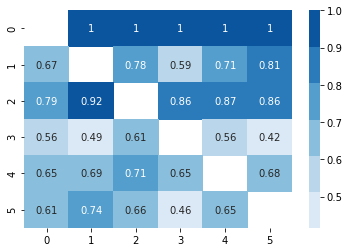

In [84]:
import seaborn as sns

ax = sns.heatmap(cond_matrix, annot=True, cmap = sns.color_palette("Blues"))

### Code from the Hackweek

In [4]:
region_a = ipd.Icesat2Data(short_name, spatial_extent, date_range)

print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.spatial_extent)

ATL06
['2019-06-01', '2019-06-05']
00:00:00
23:59:59
003
['bounding box', [-50.71, 65.73, -45.32, 68.08]]


In [5]:
region_a.avail_granules(ids=True)

['ATL06_20190601071608_09780303_003_01.h5',
 'ATL06_20190601200102_09860305_003_01.h5',
 'ATL06_20190605070748_10390303_003_01.h5',
 'ATL06_20190605195242_10470305_003_01.h5']

In [5]:
earthdata_emails = {'tsnow03':'tasha.snow@colorado.edu',
                 'fperez': 'fernando.perez@berkeley.edu',
                 'alicecima':'alice_cima@berkeley.edu'
                # add your name here
                }

user = 'tsnow03'
region_a.earthdata_login(user, earthdata_emails[user])

Earthdata Login password:  ·········


['Invalid username or password, please retry.']


Please re-enter your Earthdata user ID:  00Alifed!
Earthdata Login password:  ·


['Invalid username or password, please retry.']


Please re-enter your Earthdata user ID:  alicecima
Earthdata Login password:  ·········


In [7]:
# All possible variables
region_a.order_vars.avail(options=True)

var_list inputs: atlas_sdp_gps_epoch, control, data_end_utc, data_start_utc, end_cycle, end_delta_time, end_geoseg, end_gpssow, end_gpsweek, end_orbit, end_region, end_rgt, granule_end_utc, granule_start_utc, qa_at_interval, release, start_cycle, start_delta_time, start_geoseg, start_gpssow, start_gpsweek, start_orbit, start_region, start_rgt, version, dt_hist, fit_maxiter, fpb_maxiter, maxiter, max_res_ids, min_dist, min_gain_th, min_n_pe, min_n_sel, min_signal_conf, n_hist, nhist_bins, n_sigmas, proc_interval, qs_lim_bsc, qs_lim_hrs, qs_lim_hsigma, qs_lim_msw, qs_lim_snr, qs_lim_sss, rbin_width, sigma_beam, sigma_tx, t_dead, atl06_quality_summary, delta_time, h_li, h_li_sigma, latitude, longitude, segment_id, sigma_geo_h, fpb_mean_corr, fpb_mean_corr_sigma, fpb_med_corr, fpb_med_corr_sigma, fpb_n_corr, med_r_fit, tx_mean_corr, tx_med_corr, dem_flag, dem_h, geoid_h, dh_fit_dx, dh_fit_dx_sigma, dh_fit_dy, h_expected_rms, h_mean, h_rms_misfit, h_robust_sprd, n_fit_photons, n_seg_pulses,

In [7]:
# Choose variables to order
# region_a.order_vars.remove(all=True)
#region_a.order_vars.append(defaults=True)
#from IPython.display import JSON
#JSON(region_a.order_vars.wanted)

<IPython.core.display.JSON object>

In [6]:
region_a.order_vars.append(var_list=['latitude','longitude','h_li','h_li_sigma','atl06_quality_summary',
                                      'signal_selection_source','snr_significance','h_robust_sprd','dh_fit_dx','bsnow_conf',
                                      'cloud_flg_asr','cloud_flg_atm','msw_flag','bsnow_h','bsnow_od','layer_flag','bckgrd',
                                      'e_bckgrd','n_fit_photons','end_geoseg','segment_id','w_surface_window_final'])
from IPython.display import JSON
JSON(region_a.order_vars.wanted)

<IPython.core.display.JSON object>

Now, specify our coverage request with the wanted variables:

In [7]:
region_a.subsetparams(Coverage=region_a.order_vars.wanted);

In [8]:
region_a.order_granules()

Total number of data order requests is  1  for  4  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000701884
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete


In [9]:
# View a short list of order IDs:
region_a.granules.orderIDs

['5000000701884']

In [10]:
path = './download'
# without variable subsetting, or with variable subsetting if you have run region_a.order_granules(Coverage=region_a.order_vars.wanted)
region_a.download_granules(path)

Beginning download of zipped output...
Data request 5000000701884 of  1  order(s) is downloaded.
Download complete


In [11]:
!du -csh ./download

9.5M	./download
9.5M	total


# Build Pandas DataFrame

Some utility functions

In [12]:
import pyproj
from astropy.time import Time

def gps2dyr(time):
    """Converte GPS time to decimal years."""
    return Time(time, format='gps').decimalyear


def orbit_type(time, lat, tmax=1):
    """Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    is_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  is_asc[i_track] = True
    
    return is_asc


def transform_coord(proj1, proj2, x, y):
    """Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projections:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


In [23]:
import h5py
import numpy as np

def read_atl06(fname, outdir='data', bbox=None):
    """Read one ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
    
    # Loop trough beams
    dataframes = []  # one dataframe per track
    
    with h5py.File(fname, 'r') as fi:
        # Check which ground tracks are present in this file
        gtracks = sorted(['/'+k for k in fi.keys() if k.startswith('gt')])
        print('Available ground tracks:', gtracks)
    
        for k, g in enumerate(gtracks): 
            # Read in data for a single beam
            data = {}
            data['ground_track'] = None # Put it first in the dict for column ordering
    
            # Load vars into memory (include as many as you want)
            data['lat'] = fi[g+'/land_ice_segments/latitude'][:]
            data['lon'] = fi[g+'/land_ice_segments/longitude'][:]
            data['h_li'] = fi[g+'/land_ice_segments/h_li'][:]
            data['s_li'] = fi[g+'/land_ice_segments/h_li_sigma'][:]
            data['q_flag'] = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
            data['s_fg'] = fi[g+'/land_ice_segments/fit_statistics/signal_selection_source'][:]
            data['snr'] = fi[g+'/land_ice_segments/fit_statistics/snr_significance'][:]
            data['h_rb'] = fi[g+'/land_ice_segments/fit_statistics/h_robust_sprd'][:]
            data['dh_fit_dx'] = fi[g+'/land_ice_segments/fit_statistics/dh_fit_dx'][:]
            data['b_snow_conf'] = fi[g+'/land_ice_segments/geophysical/bsnow_conf'][:]
            
            data['c_flg_asr'] = fi[g+'/land_ice_segments/geophysical/cloud_flg_asr'][:]
            data['c_flg_atm'] = fi[g+'/land_ice_segments/geophysical/cloud_flg_atm'][:]
            data['msw'] = fi[g+'/land_ice_segments/geophysical/msw_flag'][:]
            data['bsnow_h'] = fi[g+'/land_ice_segments/geophysical/bsnow_h'][:]
            data['bsnow_od'] = fi[g+'/land_ice_segments/geophysical/bsnow_od'][:]
            data['layer_flag'] = fi[g+'/land_ice_segments/geophysical/layer_flag'][:]
            data['bckgrd'] = fi[g+'/land_ice_segments/geophysical/bckgrd'][:]
            data['e_bckgrd'] = fi[g+'/land_ice_segments/geophysical/e_bckgrd'][:]
            data['n_fit_photons'] = fi[g+'/land_ice_segments/fit_statistics/n_fit_photons'][:]
            #data['end_geoseg'] = fi['/ancillary_data/end_geoseg'][:]
            data['segment_id'] = fi[g+'/segment_quality/segment_id'][:]
            data['w_surface_window_final'] = fi[g+'/land_ice_segments/fit_statistics/w_surface_window_final'][:]

            '''
            ***Continue adding columns for these vars, repeated as above. Need to find group/file 
               structure for each in https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL06_data_dict_v003.pdf):
               cloud_flg_asr, cloud_flg_atm, msw_flag, bsnow_h, bsnow_od, layer_flag, bckgrd, 
               e_bckgrd, n_fit_photons, end_geoseg, segment_id, w_surface_window_final
            ''' 
            
#             data['dac'] = fi[g+'/land_ice_segments/geophysical/dac'][:]
#             data['t_dt'] = fi[g+'/land_ice_segments/delta_time'][:]
#             data['tide_earth'] = fi[g+'/land_ice_segments/geophysical/tide_earth'][:]
#             data['tide_load'] = fi[g+'/land_ice_segments/geophysical/tide_load'][:]
#             data['tide_ocean'] = fi[g+'/land_ice_segments/geophysical/tide_ocean'][:]
#             data['tide_pole'] = fi[g+'/land_ice_segments/geophysical/tide_pole'][:]
                
#                rgt = fi['/orbit_info/rgt'][:]                           # single value
#                 t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]     # single value
#                 beam_type = fi[g].attrs["atlas_beam_type"].decode()      # strong/weak (str)
#                 spot_number = fi[g].attrs["atlas_spot_number"].decode()  # number (str)
        
            # Assume all vector fields are of the length of the first. TODO - check?
            npts = len(data['lat'])
            data['ground_track'] = [g[1:]]*npts
                    
            # Make a dataframe out of our data dict and store it.
            dataframes.append(pd.DataFrame.from_dict(data))
        
    return dataframes

def atl06_2_df(files):
    """Return a single Pandas dataframe from a list of HDF5 ATL-06 data files.
    """
    dataframes = []
    for f in files:
        dataframes.extend(read_atl06(f))
    
    ndfs = len(dataframes)
    i = 0
    
    # pd.concat can only work with up to 10 dataframes at a time,
    # so we need to chunk this up
    new_dfs = []
    while i <= ndfs:
        i_end = i+10 if i+10 < ndfs else ndfs
        dfs = dataframes[i:i_end]
        if not dfs:
            break
        new_dfs.append(pd.concat(dfs))
        i = i_end
    
    return pd.concat(new_dfs)

In [24]:
path = Path('download')
dataf = atl06_2_df(path.glob('*.h5'))

Available ground tracks: ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
Available ground tracks: ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
Available ground tracks: ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
Available ground tracks: ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']


In [25]:
dataf.columns

Index(['ground_track', 'lat', 'lon', 'h_li', 's_li', 'q_flag', 's_fg', 'snr',
       'h_rb', 'dh_fit_dx', 'b_snow_conf', 'c_flg_asr', 'c_flg_atm', 'msw',
       'bsnow_h', 'bsnow_od', 'layer_flag', 'bckgrd', 'e_bckgrd',
       'n_fit_photons', 'segment_id', 'w_surface_window_final'],
      dtype='object')

In [ ]:
#dataf.to_csv('atl06.csv')

In [26]:
dataf.describe()

,lat,lon,h_li,s_li,q_flag,s_fg,snr,h_rb,dh_fit_dx,b_snow_conf,...,c_flg_atm,msw,bsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,segment_id,w_surface_window_final
count,252416.000000,252416.000000,2.524160e+05,2.524160e+05,252416.000000,252416.000000,252416.000000,2.524160e+05,2.524160e+05,252416.000000,...,252416.000000,252416.000000,2.524160e+05,2.524160e+05,252416.000000,2.524160e+05,2.524160e+05,2.524160e+05,252416.000000,2.524160e+05
mean,66.969175,-47.371667,inf,inf,0.022479,0.037941,0.004300,inf,inf,-0.776266,...,0.308368,0.975453,inf,inf,0.084068,inf,inf,1.155374e+07,529968.532605,inf
std,0.672515,1.208278,inf,inf,0.148235,0.291183,0.050107,inf,inf,1.771065,...,0.481262,1.418638,inf,inf,0.277490,inf,inf,1.570908e+08,125078.188503,inf
min,65.730013,-49.075188,1.244566e+03,3.356113e-03,0.000000,0.000000,0.000000,3.438600e-03,-7.799568e-01,-3.000000,...,0.000000,0.000000,5.995849e+01,9.251221e-03,0.000000,1.070931e+06,5.854139e+05,3.000000e+00,365595.000000,3.000000e+00
25%,66.391515,-48.461860,1.483578e+03,1.438970e-02,0.000000,0.000000,0.000000,1.277712e-01,-4.686356e-03,-2.000000,...,0.000000,0.000000,3.402823e+38,3.402823e+38,0.000000,2.368811e+06,7.844775e+05,1.150000e+02,375133.000000,3.000000e+00
50%,67.015728,-47.793800,1.679594e+03,2.080464e-02,0.000000,0.000000,0.000000,1.596234e-01,-8.364916e-04,-1.000000,...,0.000000,0.000000,3.402823e+38,3.402823e+38,0.000000,6.230842e+06,2.222772e+06,1.360000e+02,625393.000000,3.000000e+00
75%,67.548462,-46.083928,2.108787e+03,3.137868e-02,0.000000,0.000000,0.000000,1.908423e-01,3.726661e-03,-1.000000,...,1.000000,2.000000,3.402823e+38,3.402823e+38,0.000000,7.223469e+06,2.496404e+06,4.380000e+02,630652.000000,3.000000e+00
max,68.079999,-45.320004,3.402823e+38,3.402823e+38,1.000000,3.000000,0.941731,3.402823e+38,3.402823e+38,6.000000,...,2.000000,4.000000,3.402823e+38,3.402823e+38,1.000000,3.402823e+38,3.402823e+38,2.147484e+09,636233.000000,3.402823e+38


In [18]:
dataf.q_flag.value_counts()

0    246742
1      5674
Name: q_flag, dtype: int64

In [19]:
dataf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043409 entries, 0 to 37
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   ground_track  1043409 non-null  object 
 1   lat           1043409 non-null  float64
 2   lon           1043409 non-null  float64
 3   h_li          1043409 non-null  float32
 4   s_li          1043409 non-null  float32
 5   q_flag        1043409 non-null  int8   
 6   s_fg          1043409 non-null  int8   
 7   snr           1043409 non-null  float32
 8   h_rb          1043409 non-null  float32
 9   dh_fit_dx     1043409 non-null  float32
 10  f_sn          1043409 non-null  float32
dtypes: float32(6), float64(2), int8(2), object(1)
memory usage: 57.7+ MB
